In [859]:
from commonfunctions import *
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import utlis
from sklearn import datasets, svm, metrics
import scipy
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
os.system("clear")

pytesseract.pytesseract.tesseract_cmd = r"C:\Users\ahmed\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"


In [860]:
from commonfunctions import *
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import utlis
from sklearn import datasets, svm, metrics
import scipy
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
os.system("clear")

pytesseract.pytesseract.tesseract_cmd = r"C:\Users\ahmed\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"


In [861]:
# Functions [show, scann]

def _imshow(img):
    cv2.imshow('image', img)
    plt.show()
    # specify a wait key from keyboard
    k = cv2.waitKey(0) & 0xFF

    if k == 27: #esc in keyboard
        cv2.destroyAllWindows() #close the window   

    elif k == ord('s'): #if order is s save the image
        cv2.imwrite('Test.png', img) #write image in your pc     
        cv2.destroyAllWindows() # close the window 

def _scannar(img):
    heightImg = img.shape[1]
    widthImg  = img.shape[0]
    imgBlank = np.zeros((heightImg,widthImg, 3), np.uint8) # CREATE A BLANK IMAGE FOR TESTING DEBUGING IF REQUIRED
    # imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # CONVERT IMAGE TO GRAY SCALE
    imgBlur = cv2.GaussianBlur(img, (3, 3), 1) # ADD GAUSSIAN BLUR
    imgBlur = img

    imgsobel = sobel(imgBlur)
    imgThreshold = cv2.Canny(imgBlur,100,150) # APPLY CANNY BLUR
    kernel = np.ones((3, 3))
    imgDial = cv2.dilate(imgThreshold, kernel, iterations=2) # APPLY DILATION
    imgThreshold = cv2.erode(imgDial, kernel, iterations=1)  # APPLY EROSION



    ## FIND ALL COUNTOURS
    imgContours = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
    imgBigContour = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
    contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # FIND ALL CONTOURS
    cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 10) # DRAW ALL DETECTED CONTOURS
    imgThreshold = cv2.cvtColor(imgThreshold,cv2.COLOR_BAYER_BG2BGR)


    # FIND THE BIGGEST COUNTOUR
    biggest, maxArea = utlis.biggestContour(contours) # FIND THE BIGGEST CONTOUR

    if biggest.size != 0:
        biggest=utlis.reorder(biggest)
        cv2.drawContours(imgBigContour, biggest, -1, (0, 255, 0), 20) # DRAW THE BIGGEST CONTOUR
        imgBigContour = utlis.drawRectangle(imgBigContour,biggest,2)
        pts1 = np.float32(biggest) # PREPARE POINTS FOR WARP
        pts2 = np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))

        #REMOVE 20 PIXELS FORM EACH SIDE
        imgWarpColored=imgWarpColored[20:imgWarpColored.shape[0] - 20, 20:imgWarpColored.shape[1] - 20]

        # APPLY ADAPTIVE THRESHOLD
        imgAdaptiveThre= cv2.adaptiveThreshold(imgWarpColored, 255, 1, 1, 7, 2)
        imgAdaptiveThre = cv2.bitwise_not(imgAdaptiveThre)
        imgAdaptiveThre=cv2.medianBlur(imgWarpColored,3)

    # thres = 160
    # img_bin = np.copy(imgAdaptiveThre)
    # img_bin[imgAdaptiveThre < thres] = 0
    # img_bin[imgAdaptiveThre >= thres] = 255
    # img = img_bin
    return imgAdaptiveThre



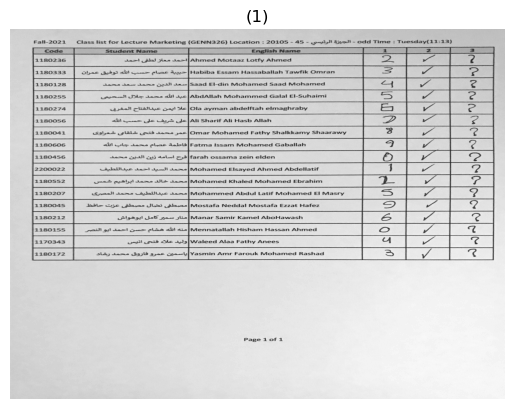

In [906]:


# read your file
file = r"E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\dataSet\11.jpg"
img = cv2.imread(file)
# img = cv2.resize(img,None,fx = 0.5,fy = 0.5)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,85,10)
# _imshow(img)
# img.shape
# scan the image
# scan = input("Do you want to scan the image?")

img = _scannar(img)
# _imshow(img)
show_images([img])

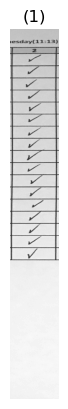

In [907]:
# thresholding the image to a binary image
thresh, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


img = img[:,img.shape[1] - 810:img.shape[1] - 420]
img_bin = img_bin[:,img_bin.shape[1] - 810:img_bin.shape[1] - 420]

# inverting the image
# img_bin = 255-img_bin
# _imshow(img_bin)
show_images([img])

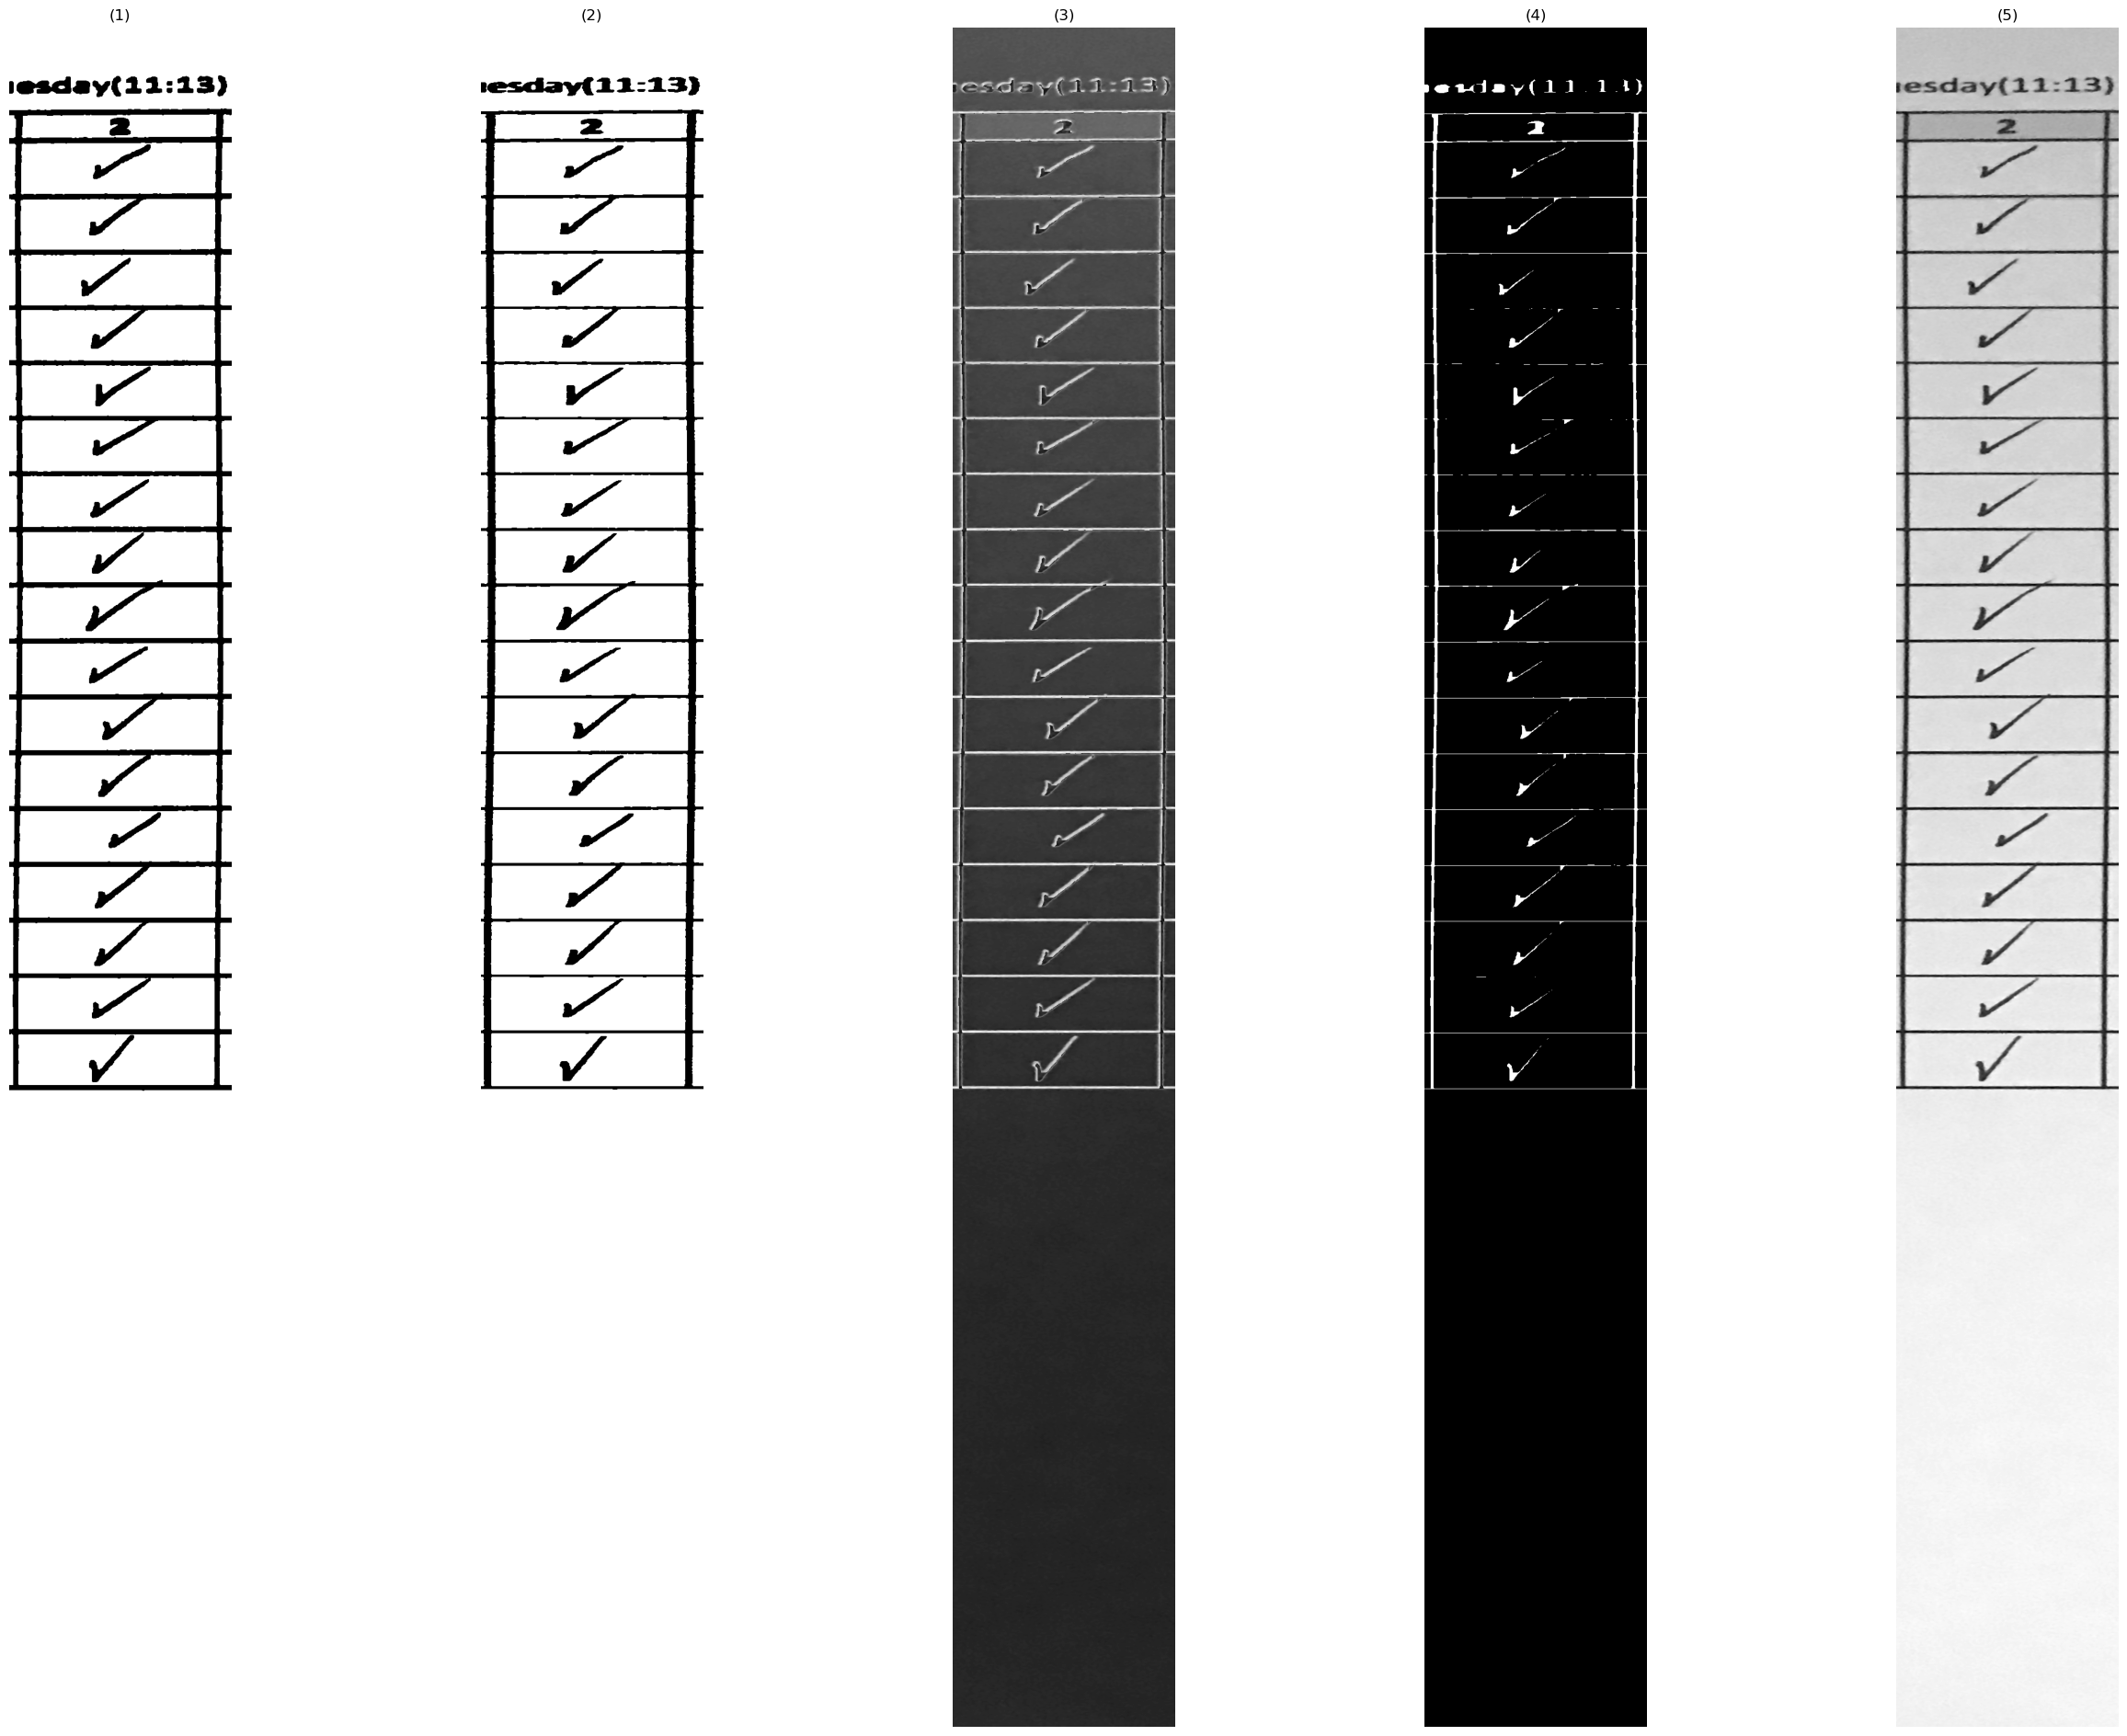

In [908]:

# Plotting the image to see the output
# plotting = plt.imshow(img_bin, cmap='gray')
# plt.show()

# countcol(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100
# Defining a vertical kernel to detect all vertical lines of image
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=2)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=2)

# Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=2)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=2)


# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
# Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=4)
thresh, img_vh = cv2.threshold(img_vh, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
bitxor = cv2.bitwise_xor(img, img_vh)
bitnot = cv2.bitwise_not(bitxor)
# Plotting the generated image
show_images([image_1,image_2,bitnot,img_vh, img])

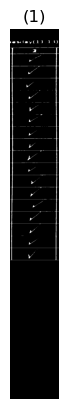

In [909]:
# Detect contours for following box detection


contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")
cont_img = np.copy(img_vh)
cv2.drawContours(cont_img, contours,7, (0, 255, 0), 1)
show_images([cont_img])
cont_img = img_vh

In [866]:
# print(contours[2])

In [867]:

# Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
# Get mean of heights
mean = np.mean(heights)
img2 = np.copy(img)
# show_images([img])



In [868]:


# Create list box to store all boxes in
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w < 10000 and w > 200  and  h < 500):
        image = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0),2)
        box.append([x, y, w, h])
# print(box)
cells_img = []
print(box[1])
for i in range(len(box)):
    img3 = img[box[i][1]:box[i][1]+box[i][3],box[i][0]:box[i][0]+box[i][2]]
    cells_img.append(img3)



[26, 190, 344, 98]


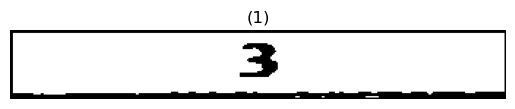

''

In [869]:

config = '8'    
cell_list = []
i = 0
img5 = cells_img[i]
_, img5 = cv2.threshold(img5,70,255,cv2.THRESH_BINARY)
show_images([img5])
pytesseract.image_to_string(img5)


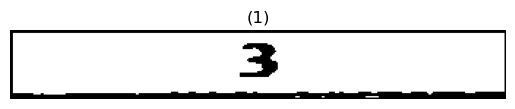

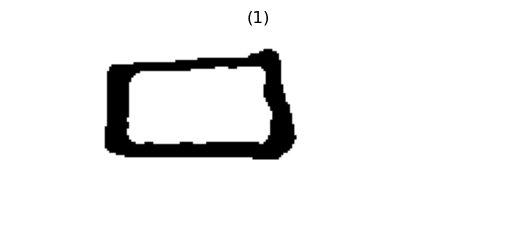

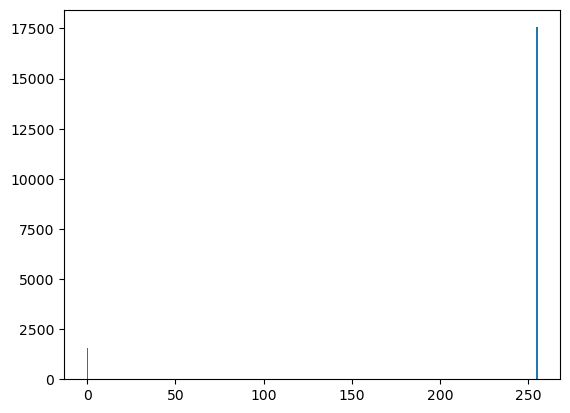

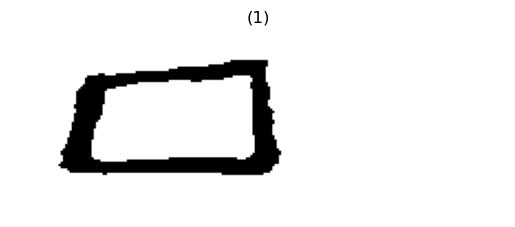

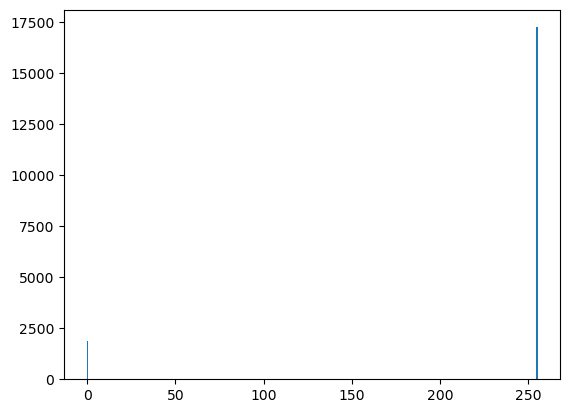

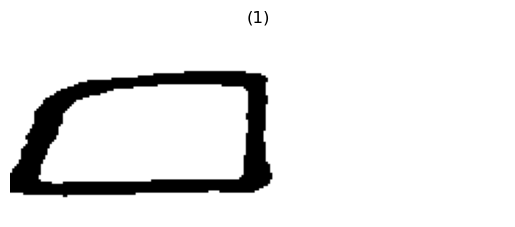

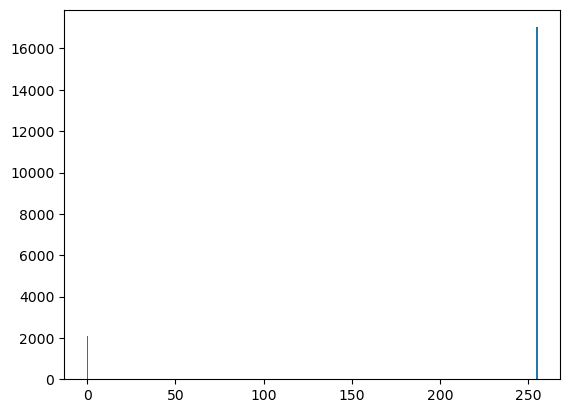

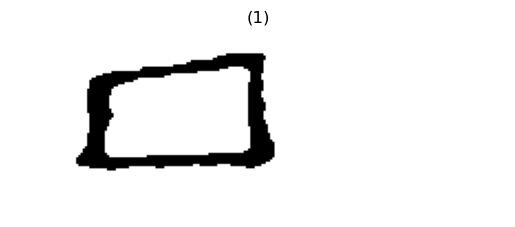

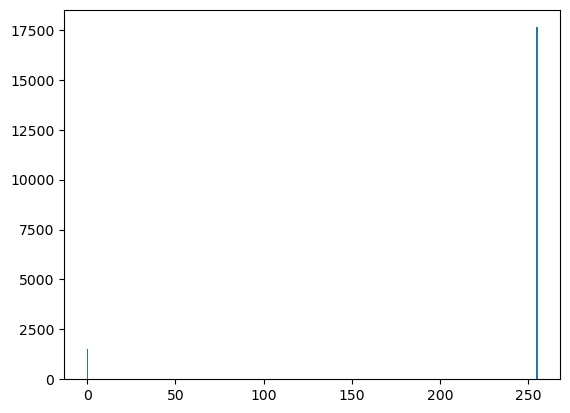

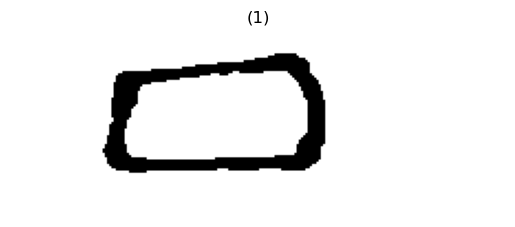

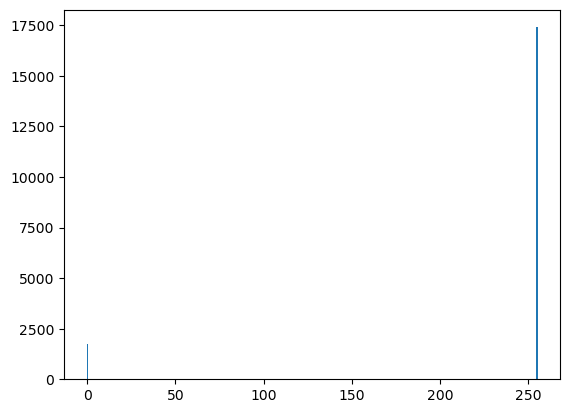

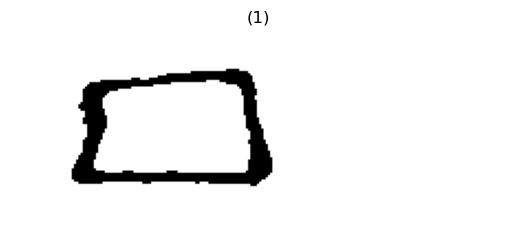

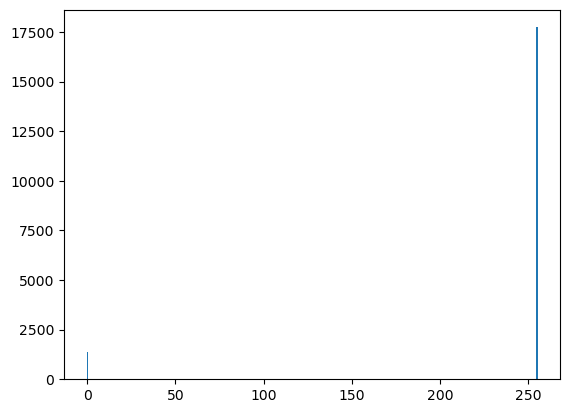

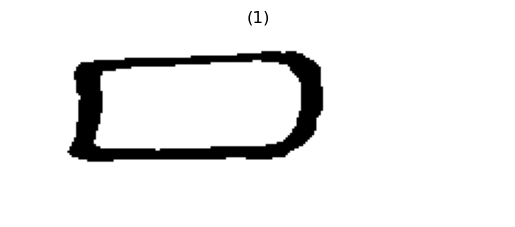

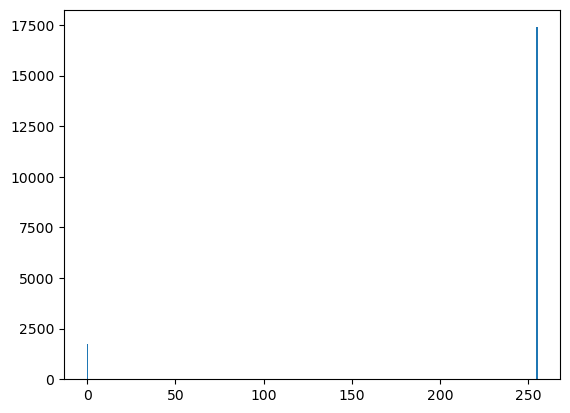

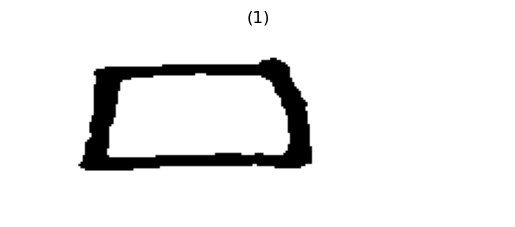

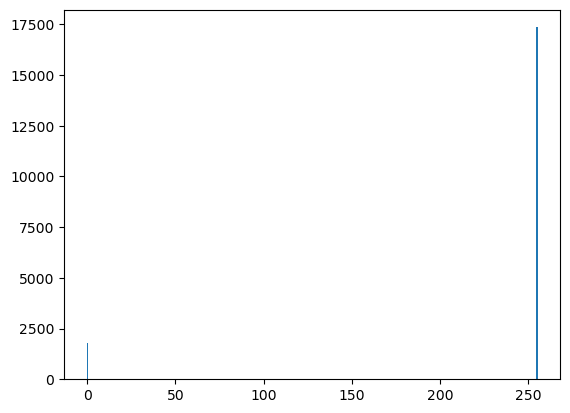

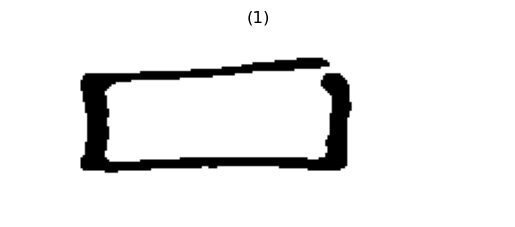

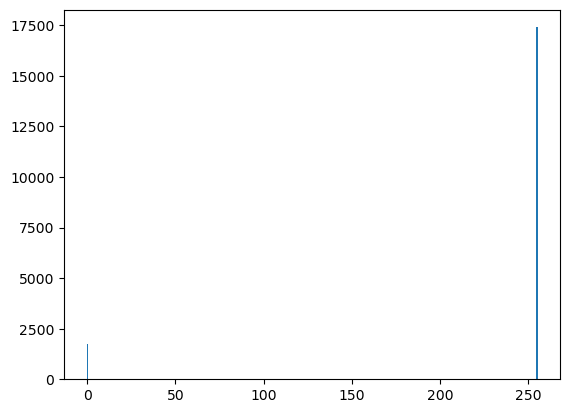

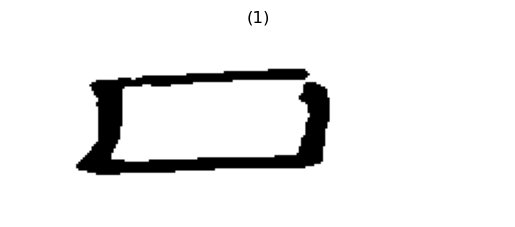

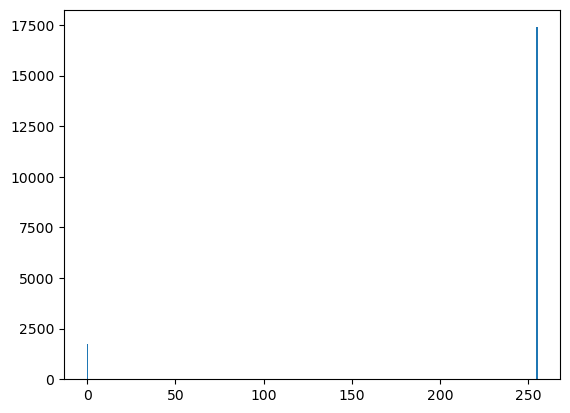

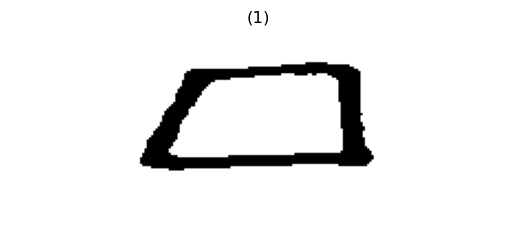

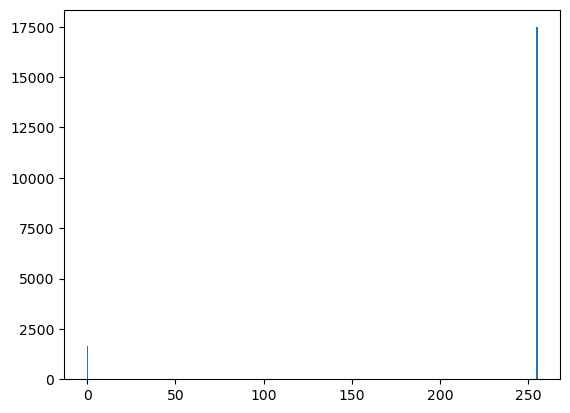

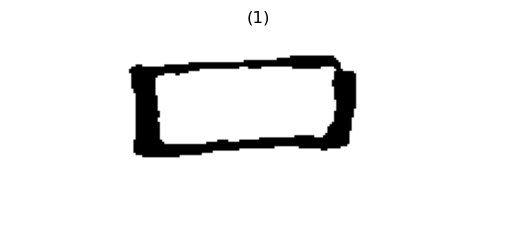

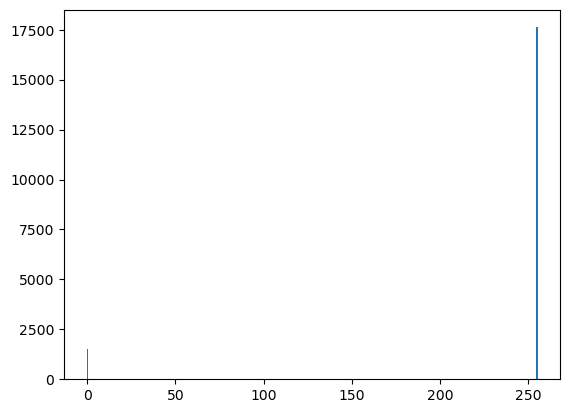

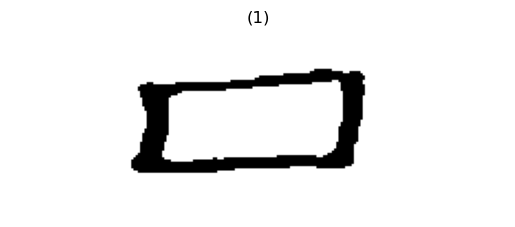

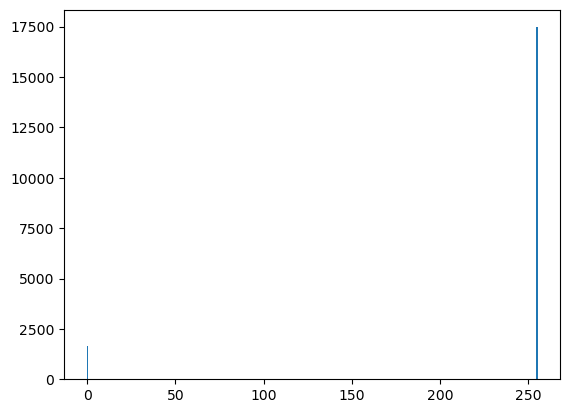

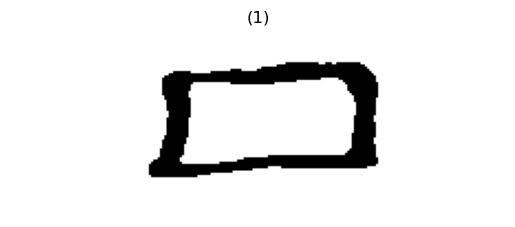

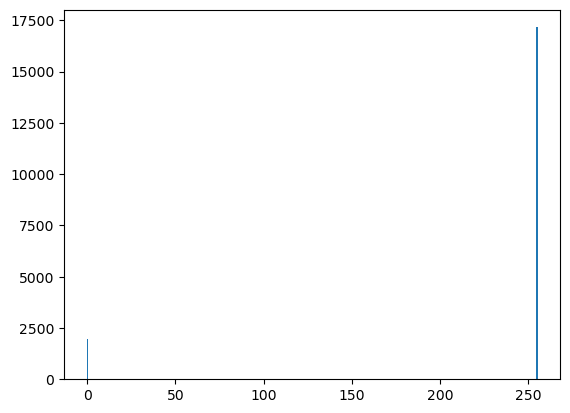

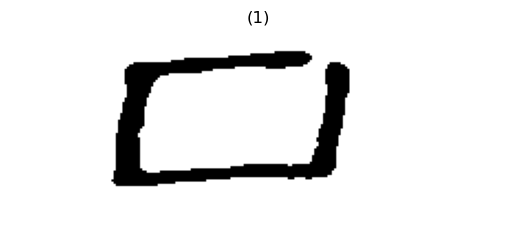

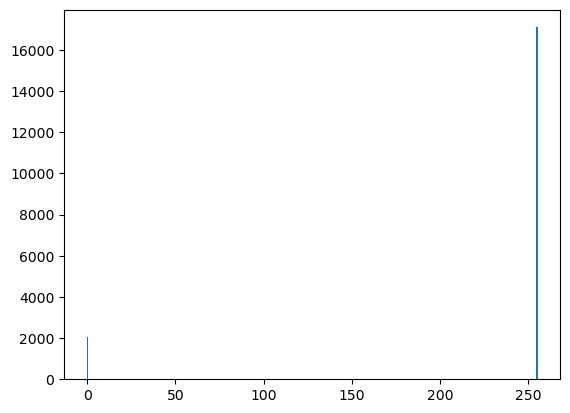

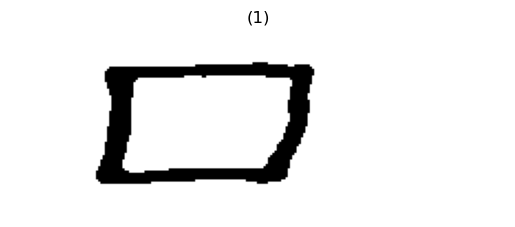

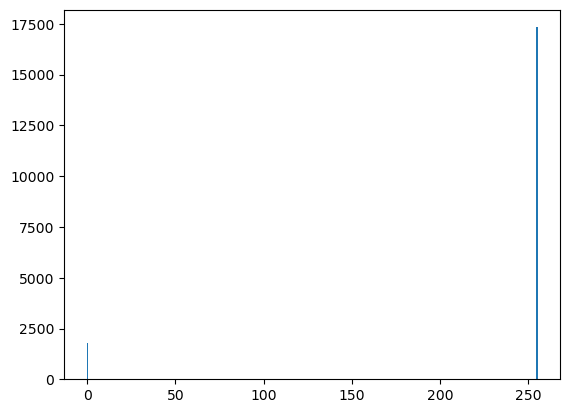

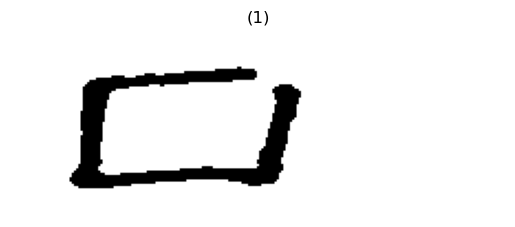

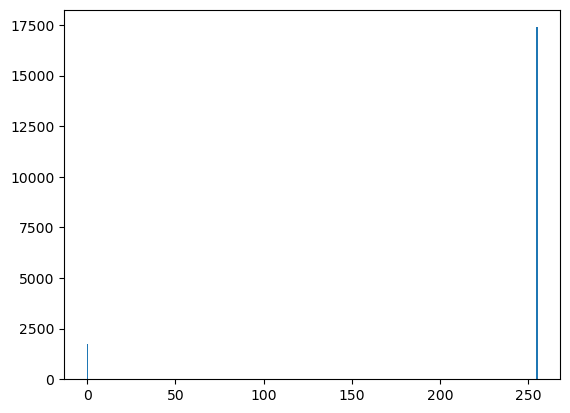

In [870]:
_, cells_img[0] = cv2.threshold(cells_img[0],70,255,cv2.THRESH_BINARY)
celltext = pytesseract.image_to_string(cells_img[0],config=config,lang="eng")
# cell_list.append(celltext)
show_images([cells_img[0]])
print(celltext)

for i in range(1,len(cells_img)):
    _, cells_img[i] = cv2.threshold(cells_img[i],120,255,cv2.THRESH_BINARY)
    # celltext = pytesseract.image_to_string(cells_img[i],config=config,lang="eng")
    # cell_list.append(celltext)
    cells_img[i] = cells_img[i][5:90,75:300]
    show_images([cells_img[i]])
    showHist(cells_img[i])
    # print(celltext)


In [896]:
cells_img = np.array(cells_img)
number = []
for i in range(cells_img.size):
    print(cells_img[i][cells_img[i] == 0].size)
    number.append(cells_img[i][cells_img[i] == 0].size)
number = np.array(number)
print(np.min(number))

2566
1566
1862
2101
1492
1723
1387
1739
1774
1724
1734
1653
1503
1656
1968
2031
1792
1743
1387


In [872]:
# print(cell_list[1])


In [873]:
# ################Excel###################

# arr = np.array(cell_list)
# dataframe = pd.DataFrame(arr)
# print(dataframe)
# data = dataframe.style.set_properties(align="left")
# # Converting it in a excel-file
# data.to_excel("E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\output.xlsx",index=None,header="code")


In [874]:
# ############# ML ####################
# # save cells:
# img6 = cells_img[1]
# show_images([img6])

# directory = '/testing'
# output_directory = '/testing'

# PRINT_SLICES = False
# THRESHOLD_PIXELS_COUNT = 60000
# MAX_BOUNDING_BOX_WIDTH = 675
# MAX_BOUNDING_BOX_HEIGHT = 50

# def detect_left_edge(image):
#     h,w = image.shape
#     max = 0
#     edge = 0
#     for x in range(0,100):

#         vertical_slice = image[0:h,  x:x+15 ]
#         vertical_slice_pixels_count = vertical_slice.sum()

#         if( vertical_slice_pixels_count > THRESHOLD_PIXELS_COUNT):
#             scipy.misc.imsave(output_directory + '/' + filename, image[0:h, x:675])
#             return 0

#         if (vertical_slice_pixels_count > max):
#             max = vertical_slice_pixels_count
#             edge = x * 2
#     return edge

# # loop over images
# for filename in os.listdir(directory):
#     if filename.endswith("negate.jpg"):
#         input_image = scipy.misc.imread(directory + '/' + filename)
#         image_height, image_width = input_image.shape
#         max = 0;
#         output_image = input_image
#         # detect top edge of the image bounding box
#         for h in range(0, image_height - MAX_BOUNDING_BOX_HEIGHT):
#             temp_image = input_image[h:h + MAX_BOUNDING_BOX_HEIGHT, 0:0 + MAX_BOUNDING_BOX_WIDTH]
#             if temp_image.sum() > max:
#                 max= temp_image.sum()
#                 output_image = temp_image
#         edge = detect_left_edge(output_image)

In [875]:

# # Creating two lists to define row and column in which cell is located
# row = []
# column = []
# j = 0

# # Sorting the boxes to their respective row and column
# for i in range(len(box)):
#     if(i == 0):
#         column.append(box[i])
#         previous = box[i]
#     else:
#         if(box[i][1] <= previous[1]+mean/2):
#             column.append(box[i])
#             previous = box[i]

#             if(i == len(box)-1):
#                 row.append(column)
#         else:
#             row.append(column)
#             column = []
#             previous = box[i]
#             column.append(box[i])
# print(column[0][0])
# print(row)
# print(box)
# # img4 = img[column[0][2]:column[0][3],column[0][0]:column[0][1]]


In [876]:

# # calculating maximum number of cells
# countcol = 0
# for i in range(len(row)):
#     countcol = len(row[i])
#     if countcol > countcol:
#         countcol = countcol

# # Retrieving the center of each column
# center = [int(row[i][j][0]+row[i][j][2]/2)
#           for j in range(len(row[i])) if row[0]]

# center = np.array(center)
# print(len(center))
# center.sort()
# print(center)
# # Regarding the distance to the columns center, the boxes are arranged in respective order
# img5 = img[:,:252]
# show_images([img5])

In [877]:

# finalboxes = []
# for i in range(len(row)):
#     lis = []
#     for k in range(countcol):
#         lis.append([])
#     for j in range(len(row[i])):
#         diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
#         minimum = min(diff)
#         indexing = list(diff).index(minimum)
#         lis[indexing].append(row[i][j])
#     finalboxes.append(lis)

# # finalboxes = box
# # print(finalboxes)
# # print(box)
# print(finalboxes[0])
# print(box[1])

In [878]:

# # from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
# outer = []
# for i in range(len(finalboxes)):
#     for j in range(len(finalboxes[i])):
#         inner = ''
#         if(len(finalboxes[i][j]) == 0):
#             outer.append(' ')
#         else:
#             for k in range(len(finalboxes[i][j])):
#                 y, x, w, h = finalboxes[i][j][k][0], finalboxes[i][j][k][1], finalboxes[i][j][k][2], finalboxes[i][j][k][3]
#                 finalimg = bitnot[x:x+h, y:y+w]
#                 kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
#                 border = cv2.copyMakeBorder(
#                     finalimg, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=[255, 255])
#                 resizing = cv2.resize(border, None, fx=2,
#                                       fy=2, interpolation=cv2.INTER_CUBIC)
#                 dilation = cv2.dilate(resizing, kernel, iterations=1)
#                 erosion = cv2.erode(dilation, kernel, iterations=2)

#                 out = pytesseract.image_to_string(erosion)
#                 if(len(out) == 0):
#                     out = pytesseract.image_to_string(
#                         erosion, config='--psm 3')
#                 inner = inner + " " + out
#             outer.append(inner)

# # Creating a dataframe of the generated OCR list
# arr = np.array(outer)
# dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
# print(dataframe)
# data = dataframe.style.set_properties(align="left")
# # Converting it in a excel-file
# data.to_excel("E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\output.xlsx")


In [879]:
# Functions [show, scann]

# def _imshow(img):
#     cv2.imshow('image', img)
#     plt.show()
#     # specify a wait key from keyboard
#     k = cv2.waitKey(0) & 0xFF

#     if k == 27: #esc in keyboard
#         cv2.destroyAllWindows() #close the window   

#     elif k == ord('s'): #if order is s save the image
#         cv2.imwrite('Test.png', img) #write image in your pc     
#         cv2.destroyAllWindows() # close the window 

# def _scannar(img):
#     heightImg = img.shape[1]
#     widthImg  = img.shape[0]
#     imgBlank = np.zeros((heightImg,widthImg, 3), np.uint8) # CREATE A BLANK IMAGE FOR TESTING DEBUGING IF REQUIRED
#     # imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # CONVERT IMAGE TO GRAY SCALE
#     imgBlur = cv2.GaussianBlur(img, (3, 3), 1) # ADD GAUSSIAN BLUR
#     imgBlur = img

#     imgsobel = sobel(imgBlur)
#     imgThreshold = cv2.Canny(imgBlur,100,150) # APPLY CANNY BLUR
#     kernel = np.ones((3, 3))
#     imgDial = cv2.dilate(imgThreshold, kernel, iterations=2) # APPLY DILATION
#     imgThreshold = cv2.erode(imgDial, kernel, iterations=1)  # APPLY EROSION



#     ## FIND ALL COUNTOURS
#     imgContours = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
#     imgBigContour = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
#     contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # FIND ALL CONTOURS
#     cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 10) # DRAW ALL DETECTED CONTOURS
#     imgThreshold = cv2.cvtColor(imgThreshold,cv2.COLOR_BAYER_BG2BGR)


#     # FIND THE BIGGEST COUNTOUR
#     biggest, maxArea = utlis.biggestContour(contours) # FIND THE BIGGEST CONTOUR

#     if biggest.size != 0:
#         biggest=utlis.reorder(biggest)
#         cv2.drawContours(imgBigContour, biggest, -1, (0, 255, 0), 20) # DRAW THE BIGGEST CONTOUR
#         imgBigContour = utlis.drawRectangle(imgBigContour,biggest,2)
#         pts1 = np.float32(biggest) # PREPARE POINTS FOR WARP
#         pts2 = np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
#         matrix = cv2.getPerspectiveTransform(pts1, pts2)
#         imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))

#         #REMOVE 20 PIXELS FORM EACH SIDE
#         imgWarpColored=imgWarpColored[20:imgWarpColored.shape[0] - 20, 20:imgWarpColored.shape[1] - 20]

#         # APPLY ADAPTIVE THRESHOLD
#         imgAdaptiveThre= cv2.adaptiveThreshold(imgWarpColored, 255, 1, 1, 7, 2)
#         imgAdaptiveThre = cv2.bitwise_not(imgAdaptiveThre)
#         imgAdaptiveThre=cv2.medianBlur(imgWarpColored,3)

#     # thres = 160
#     # img_bin = np.copy(imgAdaptiveThre)
#     # img_bin[imgAdaptiveThre < thres] = 0
#     # img_bin[imgAdaptiveThre >= thres] = 255
#     # img = img_bin
#     return imgAdaptiveThre



In [880]:


# # read your file
# file = r"E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\dataSet\13.jpg"
# img = cv2.imread(file)
# # img = cv2.resize(img,None,fx = 0.5,fy = 0.5)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# # img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,85,10)
# # _imshow(img)
# # img.shape
# # scan the image
# # scan = input("Do you want to scan the image?")

# img = _scannar(img)
# # _imshow(img)
# show_images([img])

In [881]:
# # thresholding the image to a binary image
# thresh, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# crope = 25
# img = img[:,:img.shape[1]//8 + crope]
# img_bin = img_bin[:,:img_bin.shape[1]//8 + crope]

# img8 = img[:,img.shape[1] - 480:]
# # img_bin = img_bin[:,:img_bin.shape[1]//8 + crope]

# # inverting the image
# # img_bin = 255-img_bin
# # _imshow(img_bin)
# show_images([img8])

In [882]:

# # Plotting the image to see the output
# # plotting = plt.imshow(img_bin, cmap='gray')
# # plt.show()

# # countcol(width) of kernel as 100th of total width
# kernel_len = np.array(img).shape[1]//50
# # Defining a vertical kernel to detect all vertical lines of image
# ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# # Defining a horizontal kernel to detect all horizontal lines of image
# hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len+2, 1))
# # A kernel of 2x2
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# # Use vertical kernel to detect and save the vertical lines in a jpg
# image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
# vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=4)

# # Use horizontal kernel to detect and save the horizontal lines in a jpg
# image_2 = cv2.erode(img_bin, hor_kernel, iterations=10)
# horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=10)


# # Combine horizontal and vertical lines in a new third image, with both having same weight.
# img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
# # Eroding and thesholding the image
# img_vh = cv2.erode(~img_vh, kernel, iterations=4)
# thresh, img_vh = cv2.threshold(img_vh, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# bitxor = cv2.bitwise_xor(img, img_vh)
# bitnot = cv2.bitwise_not(bitxor)
# # Plotting the generated image
# show_images([image_1,image_2,bitnot,img_vh, img])

In [883]:
# # Detect contours for following box detection


# contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


# def sort_contours(cnts, method="left-to-right"):
#     # initialize the reverse flag and sort index
#     reverse = False
#     i = 0
#     # handle if we need to sort in reverse
#     if method == "right-to-left" or method == "bottom-to-top":
#         reverse = True
#     # handle if we are sorting against the y-coordinate rather than
#     # the x-coordinate of the bounding box
#     if method == "top-to-bottom" or method == "bottom-to-top":
#         i = 1
#     # construct the list of bounding boxes and sort them from top to
#     # bottom
#     boundingBoxes = [cv2.boundingRect(c) for c in cnts]
#     (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))
#     # return the list of sorted contours and bounding boxes
#     return (cnts, boundingBoxes)


# # Sort all the contours by top to bottom.
# contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")
# cont_img = np.copy(img_vh)
# cv2.drawContours(cont_img, contours,7, (0, 255, 0), 1)
# show_images([cont_img])
# cont_img = img_vh

In [884]:
# print(contours[2])

In [885]:

# # Creating a list of heights for all detected boxes
# heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
# # Get mean of heights
# mean = np.mean(heights)
# img2 = np.copy(img)
# # show_images([img])



In [886]:
# #

# # Create list box to store all boxes in
# box = []
# # Get position (x,y), width and height for every contour and show the contour on image
# for c in contours:
#     x, y, w, h = cv2.boundingRect(c)
#     if (w < 10000 and w > 200  and  h < 500):
#         # image = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0),1)
#         box.append([x, y, w, h])
# # print(box)
# cells_img = []
# print(box[1])
# for i in range(len(box)):
#     img3 = img[box[i][1]:box[i][1]+box[i][3],box[i][0]:box[i][0]+box[i][2]]
#     cells_img.append(img3)



In [887]:

# config = '8'    
# cell_list = []
# i = 0
# img5 = cells_img[i]
# _, img5 = cv2.threshold(img5,70,255,cv2.THRESH_BINARY)
# show_images([img5])
# pytesseract.image_to_string(img5)


In [888]:
# _, cells_img[0] = cv2.threshold(cells_img[0],70,255,cv2.THRESH_BINARY)
# celltext = pytesseract.image_to_string(cells_img[0],config=config,lang="eng")
# cell_list.append(celltext)
# show_images([cells_img[0]])
# print(celltext)

# for i in range(1,len(cells_img)):
#     _, cells_img[i] = cv2.threshold(cells_img[i],90,255,cv2.THRESH_BINARY)
#     celltext = pytesseract.image_to_string(cells_img[i],config=config,lang="eng")
#     cell_list.append(celltext)
#     show_images([cells_img[i]])
#     print(celltext)


In [889]:
# print(cell_list[1])


In [890]:
# ################Excel###################

# arr = np.array(cell_list)
# dataframe = pd.DataFrame(arr)
# print(dataframe)
# data = dataframe.style.set_properties(align="left")
# # Converting it in a excel-file
# data.to_excel("E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\output.xlsx",index=None,header="code")


In [891]:
# ############# ML ####################
# # save cells:
# img6 = cells_img[1]
# show_images([img6])

# directory = '/testing'
# output_directory = '/testing'

# PRINT_SLICES = False
# THRESHOLD_PIXELS_COUNT = 60000
# MAX_BOUNDING_BOX_WIDTH = 675
# MAX_BOUNDING_BOX_HEIGHT = 50

# def detect_left_edge(image):
#     h,w = image.shape
#     max = 0
#     edge = 0
#     for x in range(0,100):

#         vertical_slice = image[0:h,  x:x+15 ]
#         vertical_slice_pixels_count = vertical_slice.sum()

#         if( vertical_slice_pixels_count > THRESHOLD_PIXELS_COUNT):
#             scipy.misc.imsave(output_directory + '/' + filename, image[0:h, x:675])
#             return 0

#         if (vertical_slice_pixels_count > max):
#             max = vertical_slice_pixels_count
#             edge = x * 2
#     return edge

# # loop over images
# for filename in os.listdir(directory):
#     if filename.endswith("negate.jpg"):
#         input_image = scipy.misc.imread(directory + '/' + filename)
#         image_height, image_width = input_image.shape
#         max = 0;
#         output_image = input_image
#         # detect top edge of the image bounding box
#         for h in range(0, image_height - MAX_BOUNDING_BOX_HEIGHT):
#             temp_image = input_image[h:h + MAX_BOUNDING_BOX_HEIGHT, 0:0 + MAX_BOUNDING_BOX_WIDTH]
#             if temp_image.sum() > max:
#                 max= temp_image.sum()
#                 output_image = temp_image
#         edge = detect_left_edge(output_image)

In [892]:

# # Creating two lists to define row and column in which cell is located
# row = []
# column = []
# j = 0

# # Sorting the boxes to their respective row and column
# for i in range(len(box)):
#     if(i == 0):
#         column.append(box[i])
#         previous = box[i]
#     else:
#         if(box[i][1] <= previous[1]+mean/2):
#             column.append(box[i])
#             previous = box[i]

#             if(i == len(box)-1):
#                 row.append(column)
#         else:
#             row.append(column)
#             column = []
#             previous = box[i]
#             column.append(box[i])
# print(column[0][0])
# print(row)
# print(box)
# # img4 = img[column[0][2]:column[0][3],column[0][0]:column[0][1]]


In [893]:

# # calculating maximum number of cells
# countcol = 0
# for i in range(len(row)):
#     countcol = len(row[i])
#     if countcol > countcol:
#         countcol = countcol

# # Retrieving the center of each column
# center = [int(row[i][j][0]+row[i][j][2]/2)
#           for j in range(len(row[i])) if row[0]]

# center = np.array(center)
# print(len(center))
# center.sort()
# print(center)
# # Regarding the distance to the columns center, the boxes are arranged in respective order
# img5 = img[:,:252]
# show_images([img5])

In [894]:

# finalboxes = []
# for i in range(len(row)):
#     lis = []
#     for k in range(countcol):
#         lis.append([])
#     for j in range(len(row[i])):
#         diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
#         minimum = min(diff)
#         indexing = list(diff).index(minimum)
#         lis[indexing].append(row[i][j])
#     finalboxes.append(lis)

# # finalboxes = box
# # print(finalboxes)
# # print(box)
# print(finalboxes[0])
# print(box[1])

In [895]:

# # from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
# outer = []
# for i in range(len(finalboxes)):
#     for j in range(len(finalboxes[i])):
#         inner = ''
#         if(len(finalboxes[i][j]) == 0):
#             outer.append(' ')
#         else:
#             for k in range(len(finalboxes[i][j])):
#                 y, x, w, h = finalboxes[i][j][k][0], finalboxes[i][j][k][1], finalboxes[i][j][k][2], finalboxes[i][j][k][3]
#                 finalimg = bitnot[x:x+h, y:y+w]
#                 kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
#                 border = cv2.copyMakeBorder(
#                     finalimg, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=[255, 255])
#                 resizing = cv2.resize(border, None, fx=2,
#                                       fy=2, interpolation=cv2.INTER_CUBIC)
#                 dilation = cv2.dilate(resizing, kernel, iterations=1)
#                 erosion = cv2.erode(dilation, kernel, iterations=2)

#                 out = pytesseract.image_to_string(erosion)
#                 if(len(out) == 0):
#                     out = pytesseract.image_to_string(
#                         erosion, config='--psm 3')
#                 inner = inner + " " + out
#             outer.append(inner)

# # Creating a dataframe of the generated OCR list
# arr = np.array(outer)
# dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
# print(dataframe)
# data = dataframe.style.set_properties(align="left")
# # Converting it in a excel-file
# data.to_excel("E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\output.xlsx")
